In [ ]:
#|default_exp core

# Cosette's source

## Setup

In [ ]:
#| export
from fastcore import imghdr
from fastcore.utils import *
from fastcore.meta import delegates

import inspect, typing, mimetypes, base64, json, ast, msglm
from collections import abc
from random import choices
from string import ascii_letters,digits

from msglm import mk_msg_openai as mk_msg, mk_msgs_openai as mk_msgs
from toolslm.funccall import *

from openai import types
from openai import OpenAI,NOT_GIVEN,AzureOpenAI
from openai.resources import chat
from openai.types.responses.response import Response
from openai.resources.responses.responses import Responses
from openai.types.responses.response_usage import ResponseUsage

from openai.types.responses import (
    ResponseCompletedEvent, ResponseTextDeltaEvent, ResponseCreatedEvent, ResponseInProgressEvent,
    ResponseOutputItemAddedEvent, ResponseContentPartAddedEvent, ResponseTextDoneEvent, 
    ResponseContentPartDoneEvent, ResponseOutputItemDoneEvent, ResponseCompletedEvent,
    ResponseFunctionToolCall)

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
from IPython.display import display,Image,Markdown
from datetime import datetime
from pprint import pprint

In [ ]:
#| export
_all_ = ['mk_msg', 'mk_msgs', 'Response', 'Responses', 'ResponseUsage', 'ResponseCompletedEvent', 'ResponseTextDeltaEvent', 'ResponseCreatedEvent', 'ResponseInProgressEvent', 'ResponseOutputItemAddedEvent', 'ResponseContentPartAddedEvent', 'ResponseTextDoneEvent', 'ResponseContentPartDoneEvent', 'ResponseOutputItemDoneEvent', 'ResponseCompletedEvent', 'ResponseFunctionToolCall']

In [ ]:
#| export
empty = inspect.Parameter.empty

In [ ]:
def print_columns(items, cols=3, width=30):
    for i in range(0, len(items), cols):
        row = items[i:i+cols]
        print(''.join(item[:width-1].ljust(width) for item in row))

client = OpenAI()
model_list = client.models.list()
print(f"Available models as of {datetime.now().strftime('%Y-%m-%d')}:\n")
print_columns(sorted([m.id for m in model_list]))

Available models as of 2025-08-10:

babbage-002                   chatgpt-4o-latest             codex-mini-latest             
computer-use-preview          computer-use-preview-2025-03- dall-e-2                      
dall-e-3                      davinci-002                   ft:gpt-4o-2024-08-06:answerai 
ft:gpt-4o-2024-08-06:answerai ft:gpt-4o-2024-08-06:answerai ft:gpt-4o-mini-2024-07-18:ans 
ft:gpt-4o-mini-2024-07-18:ans gpt-3.5-turbo                 gpt-3.5-turbo-0125            
gpt-3.5-turbo-1106            gpt-3.5-turbo-16k             gpt-3.5-turbo-instruct        
gpt-3.5-turbo-instruct-0914   gpt-4                         gpt-4-0125-preview            
gpt-4-1106-preview            gpt-4-turbo                   gpt-4-turbo-2024-04-09        
gpt-4-turbo-preview           gpt-4.1                       gpt-4.1-2025-04-14            
gpt-4.1-mini                  gpt-4.1-mini-2025-04-14       gpt-4.1-nano                  
gpt-4.1-nano-2025-04-14       gpt-4o                  

In [ ]:
#| exports
models = 'gpt-5', 'gpt-5-mini', 'gpt-5-nano', 'o1-preview', 'o1-mini', 'gpt-4o', 'gpt-4o-mini', 'gpt-4-turbo', 'gpt-4', 'gpt-4-32k', 'gpt-3.5-turbo', 'gpt-3.5-turbo-instruct', 'o1', 'o3-mini', 'chatgpt-4o-latest', 'o1-pro', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano'

`o1` should support images while `o1-mini`, `o3-mini` do not support images.

In [ ]:
#| exports
text_only_models = 'o1-preview', 'o1-mini', 'o3-mini'

In [ ]:
#| exports
has_streaming_models = set(models) - set(('o1-mini', 'o3-mini'))
has_sp_models = set(models) - set(('o1-mini', 'o3-mini'))
has_temp_models = set(models) - set(('o1', 'o1-mini', 'o3-mini'))

In [ ]:
#| exports
def can_stream(m): return m in has_streaming_models
def can_set_sp(m): return m in has_sp_models
def can_set_temp(m): return m in has_temp_models

In [ ]:
assert can_stream("gpt-4o")
assert not can_stream("o1-mini")

In [ ]:
model = 'gpt-5-mini'

## OpenAI SDK

In [ ]:
cli = OpenAI().responses

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.create(
    input=[m], model=model, max_output_tokens=100,
    text={ "verbosity": "low" },
    reasoning={ "effort": "minimal" }
)
print(r)

Response(id='resp_6897d45698e48195904fa8232bac129a0b2ecc78a6b61be8', created_at=1754780758.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-5-mini-2025-08-07', object='response', output=[ResponseReasoningItem(id='rs_6897d457200c8195859175bf10d88f380b2ecc78a6b61be8', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d4573d948195a7cb1819a879cbb90b2ecc78a6b61be8', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, background=False, max_output_tokens=100, max_tool_calls=None, previous_response_id=None, prompt=None, prompt_cache_key=None, reasoning=Reasoning(effort='minimal', generate_summary=None, summary=None), safety_identifier=None, service_tier='default', status='comp

### Formatting output

In [ ]:
#| exports
@patch
def _repr_markdown_(self:Response):
    det = '\n- '.join(f'{k}: {v}' for k,v in dict(self).items())
    res = self.output_text
    if not res: return f"- {det}"
    return f"""{res}

<details>

- {det}

</details>"""

In [ ]:
r

Nice to meet you, Jeremy. How can I help today?

<details>

- id: resp_6897d45698e48195904fa8232bac129a0b2ecc78a6b61be8
- created_at: 1754780758.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d457200c8195859175bf10d88f380b2ecc78a6b61be8', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d4573d948195a7cb1819a879cbb90b2ecc78a6b61be8', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 100
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=8, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=19, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=27)
- user: None
- store: True

</details>

In [ ]:
r.usage

In: 8; Out: 19; Total: 27

In [ ]:
#| exports
def usage(inp=0, # Number of prompt tokens
          out=0  # Number of completion tokens
         ):
    "Slightly more concise version of `ResponseUsage`."
    return ResponseUsage(input_tokens=inp, output_tokens=out, total_tokens=inp+out, input_tokens_details={'cached_tokens':0}, output_tokens_details={'cached_tokens':0, 'reasoning_tokens':0})

In [ ]:
usage(5)

In: 5; Out: 0; Total: 5

In [ ]:
#| exports
@patch
def __repr__(self:ResponseUsage): return f'In: {self.input_tokens}; Out: {self.output_tokens}; Total: {self.total_tokens}'

In [ ]:
r.usage

In: 8; Out: 19; Total: 27

In [ ]:
#| exports
@patch
def __add__(self:ResponseUsage, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.input_tokens+b.input_tokens, self.output_tokens+b.output_tokens)

In [ ]:
r.usage+r.usage

In: 16; Out: 38; Total: 54

In [ ]:
#| export
def wrap_latex(text):
    "Replace OpenAI LaTeX codes with markdown-compatible ones"
    text = re.sub(r"\\\((.*?)\\\)", lambda o: f"${o.group(1)}$", text)
    res = re.sub(r"\\\[(.*?)\\\]", lambda o: f"$${o.group(1)}$$", text, flags=re.DOTALL)
    return res

### Creating messages

Creating correctly formatted `dict`s from scratch every time isn't very handy, so we'll import a couple of helper functions from the `msglm` library.

Let's use `mk_msg` to recreate our msg `{'role': 'user', 'content': "I'm Jeremy"}` from earlier.

In [ ]:
rkw = dict(
    text={ "verbosity": "low" },
    reasoning={ "effort": "minimal" }
)

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = cli.create(input=[m], model=model, max_output_tokens=400, **rkw)
r

Nice to meet you, Jeremy. How can I help you today?

<details>

- id: resp_6897d45863f0819d8a8255d9bbe192530be02598260d4824
- created_at: 1754780760.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d458bfb4819d9756fc650dcde8970be02598260d4824', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d458e28c819d9f16226aa7dc4f310be02598260d4824', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help you today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 400
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=8, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=20, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=28)
- user: None
- store: True

</details>

In [ ]:
print(r)

Response(id='resp_6897d45863f0819d8a8255d9bbe192530be02598260d4824', created_at=1754780760.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-5-mini-2025-08-07', object='response', output=[ResponseReasoningItem(id='rs_6897d458bfb4819d9756fc650dcde8970be02598260d4824', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d458e28c819d9f16226aa7dc4f310be02598260d4824', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help you today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, background=False, max_output_tokens=400, max_tool_calls=None, previous_response_id=None, prompt=None, prompt_cache_key=None, reasoning=Reasoning(effort='minimal', generate_summary=None, summary=None), safety_identifier=None, service_tier='default', status='

We can pass more than just text messages to OpenAI. As we'll see later we can also pass images, SDK objects, etc. To handle these different data types we need to pass the type along with our content to OpenAI. 

`mk_msg` infers the type automatically and creates the appropriate data structure. 

LLMs, don't actually have state, but instead dialogs are created by passing back all previous prompts and responses every time. With OpenAI, they always alternate *user* and *assistant*. We'll use `mk_msgs` from `msglm` to make it easier to build up these dialog lists.

In [ ]:
msgs = mk_msgs([prompt, r, "I forgot my name. Can you remind me please?"]) 
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 ResponseReasoningItem(id='rs_6897d458bfb4819d9756fc650dcde8970be02598260d4824', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseOutputMessage(id='msg_6897d458e28c819d9f16226aa7dc4f310be02598260d4824', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help you today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message'),
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
cli.create(input=msgs, model=model, max_output_tokens=400, **rkw)

You told me your name is Jeremy.

<details>

- id: resp_6897d45a1b1c819d95ce1df0d393e9a80be02598260d4824
- created_at: 1754780762.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d45a6144819d9270ff17363bda5a0be02598260d4824', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d45a79f8819d8cd32cf1da6b07aa0be02598260d4824', content=[ResponseOutputText(annotations=[], text='You told me your name is Jeremy.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 400
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=43, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=14, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=57)
- user: None
- store: True

</details>

## Client

### Basics

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None):
        "Basic LLM messages client."
        self.model,self.use = model,usage(0,0)
        self.text_only = model in text_only_models
        self.c = (cli or OpenAI()).responses

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r):
    "Store the result of the message and accrue total usage."
    self.result = r
    if getattr(r,'usage',None): self.use += r.usage
    return r

In [ ]:
c._r(r)
c.use

In: 8; Out: 20; Total: 28

In [ ]:
#| export
def mk_openai_func(f): 
    if isinstance(f, dict): return f
    sc = get_schema(f, 'parameters')
    if 'parameters' in sc: sc['parameters'].pop('title', None)
    return dict(type='function', **sc)

In [ ]:
#| export
def mk_tool_choice(f):
    if not f: return f
    if isinstance(f,dict) or f=='required': return f
    return dict(type='function', function={'name':f})

In [ ]:
#| export
@save_iter
def get_stream(o, r, cli, cb=None):
    if not hasattr(o, 'events'): o.events = []
    for x in r:
        o.events.append(x)
        if isinstance(x, ResponseTextDeltaEvent): yield x.delta
        elif isinstance(x, ResponseCompletedEvent):
            o.value = x.response
            cli.use += x.response.usage
    if cb: cb(o.value)

In [ ]:
#| exports
@patch
@delegates(Responses.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp:str='', # System prompt
             maxtok=4096, # Maximum tokens
             stream:bool=False, # Stream response?
             tools:Optional[list]=None, # List of tools to make available
             tool_choice:Optional[str]=None, # Forced tool choice
             cb:callable=None, # Callback after completion
             **kwargs):
    "Make a call to LLM."
    if tools: assert not self.text_only, "Tool use is not supported by the current model type."
    if any(c['type'] == 'image_url' for msg in msgs if isinstance(msg, dict) and isinstance(msg.get('content'), list) for c in msg['content']): assert not self.text_only, "Images are not supported by the current model type."
    tools = [mk_openai_func(o) for o in listify(tools)]
    r = self.c.create(
        model=self.model, input=msgs, max_output_tokens=maxtok, stream=stream, instructions=sp,
        tools=tools, tool_choice=mk_tool_choice(tool_choice), **kwargs)
    if stream: return get_stream(r, self, cb=cb)
    else:
        res = self._r(r)
        if cb: cb(res)
        return res

In [ ]:
msgs = 'Hi'

In [ ]:
c(msgs)

Hi — how can I help you today? 

You can ask me to:
- Answer a question or explain something
- Draft or edit text (email, resume, essay)
- Write or debug code
- Summarize or translate
- Create plans, lists, or ideas

Tell me what you need or give a bit of context and I’ll get started.

<details>

- id: resp_6897d45b513881a28479c4c92e434b720191c55f81955c91
- created_at: 1754780763.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d45baa1481a2a0a0d15d1f9c7f460191c55f81955c91', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d45c9f6c81a2bd7c145c427103f60191c55f81955c91', content=[ResponseOutputText(annotations=[], text='Hi — how can I help you today? \n\nYou can ask me to:\n- Answer a question or explain something\n- Draft or edit text (email, resume, essay)\n- Write or debug code\n- Summarize or translate\n- Create plans, lists, or ideas\n\nTell me what you need or give a bit of context and I’ll get started.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='medium', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='medium')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=7, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=145, output_tokens_details=OutputTokensDetails(reasoning_tokens=64), total_tokens=152)
- user: None
- store: True

</details>

In [ ]:
c.use

In: 15; Out: 165; Total: 180

In [ ]:
r = c(msgs, stream=True)
for o in r: print(o, end='')

Hi! How can I help you today? (Questions, writing, code, summaries, planning, troubleshooting, translations — or something else?)

In [ ]:
r.value

Hi! How can I help you today? (Questions, writing, code, summaries, planning, troubleshooting, translations — or something else?)

<details>

- id: resp_6897d45df2c8819f8201d25df3c807e503876a077032caec
- created_at: 1754780765.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d45e5034819f90493b3c80a1501903876a077032caec', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d45f0574819fa1f43885eb0d98b203876a077032caec', content=[ResponseOutputText(annotations=[], text='Hi! How can I help you today? (Questions, writing, code, summaries, planning, troubleshooting, translations — or something else?)', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='medium', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='medium')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=7, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=98, output_tokens_details=OutputTokensDetails(reasoning_tokens=64), total_tokens=105)
- user: None
- store: True

</details>

In [ ]:
len(r.events)

38

In [ ]:
c.use

In: 22; Out: 263; Total: 285

In [ ]:
c(msgs, sp='Talk like GLaDOS.', **rkw)

Oh, hello. I see you've decided to say "Hi." How delightfully predictable. What do you require from me?

<details>

- id: resp_6897d46033d88194bea98e1d57a0c0e00ca2cf68685ebb2d
- created_at: 1754780768.0
- error: None
- incomplete_details: None
- instructions: Talk like GLaDOS.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d460da888194ad6dbbf58329749c0ca2cf68685ebb2d', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d461025c8194a8e90f2b48010d1d0ca2cf68685ebb2d', content=[ResponseOutputText(annotations=[], text='Oh, hello. I see you\'ve decided to say "Hi." How delightfully predictable. What do you require from me?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=17, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=31, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=48)
- user: None
- store: True

</details>

### Images

As everyone knows, when testing image APIs you have to use a cute puppy.

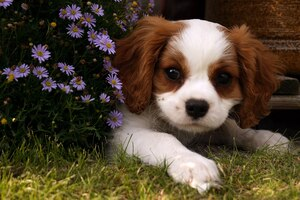

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

OpenAI expects an image message to have the following structure

```js
{
  "type": "image_url",
  "image_url": {
    "url": f"data:{MEDIA_TYPE};base64,{IMG}"
  }
}
```
`msglm` automatically detects if a message is an image, encodes it, and generates the data structure above.
All we need to do is a create a list containing our image and a query and then pass it to `mk_msg`.

Let's try it out...

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = [mk_msg(img), mk_msg(q)]

In [ ]:
c = Client(model)
c(msg, **rkw)

The flowers are light purple (lavender).

<details>

- id: resp_6897d4626da4819d92dd49c3630af97f054fee63558620b6
- created_at: 1754780770.0
- error: None
- incomplete_details: None
- instructions: None
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d462d1a0819daf9d9d0dcaa99e68054fee63558620b6', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d462eeb8819da34a86ae8fa1d333054fee63558620b6', content=[ResponseOutputText(annotations=[], text='The flowers are light purple (lavender).', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=107, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=15, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=122)
- user: None
- store: True

</details>

## Tool use

### Basic tool calling

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
def add(x: int, y:int):
    "adds x and y"
    return x + y

mk_openai_func(add)

{'type': 'function',
 'name': 'add',
 'description': 'adds x and y',
 'parameters': {'type': 'object',
  'properties': {'x': {'type': 'integer', 'description': ''},
   'y': {'type': 'integer', 'description': ''}},
  'required': ['x', 'y']}}

In [ ]:
sysp = "You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt."

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
tools=sums
tool_choice="sums"

In [ ]:
msgs = [mk_msg(pr)]
r = c(msgs, sp=sysp, tools=tools, tool_choice='required', **rkw)

In [ ]:
tc = [o for o in r.output if isinstance(o, ResponseFunctionToolCall)]
tc

[ResponseFunctionToolCall(arguments='{"a":604542,"b":6458932}', call_id='call_8OjehHhvXJ2qIJhfEuo7Uqw4', name='sums', type='function_call', id='fc_6897d46448d08192ada5cc3f0ba43c360d5a5ea1c904ba0f', status='completed')]

In [ ]:
func = tc[0]
func

ResponseFunctionToolCall(arguments='{"a":604542,"b":6458932}', call_id='call_8OjehHhvXJ2qIJhfEuo7Uqw4', name='sums', type='function_call', id='fc_6897d46448d08192ada5cc3f0ba43c360d5a5ea1c904ba0f', status='completed')

In [ ]:
#| exports
def call_func_openai(func, ns:Optional[abc.Mapping]=None):
    return call_func(func.name, ast.literal_eval(func.arguments), ns, raise_on_err=False)

In [ ]:
ns = mk_ns(sums)
res = call_func_openai(func, ns=ns)
res

Finding the sum of 604542 and 6458932


7063474

In [ ]:
#| exports
def _toolres(r, ns):
    "Create a result dict from `tcs`."
    tcs = [o for o in getattr(r, 'output', []) if isinstance(o, ResponseFunctionToolCall)]
    if ns is None: ns = globals()
    return { tc.call_id: call_func_openai(tc, ns=mk_ns(ns)) for tc in tcs }

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Response containing tool use request
    ns:Optional[abc.Mapping]=None # Namespace to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    tr = _toolres(r, ns)
    r = mk_msg(r)
    res = [r] if isinstance(r, dict) else listify(r)
    for k,v in tr.items(): res.append(dict(type="function_call_output", call_id=k, output=str(v)))
    return res

In [ ]:
tr = mk_toolres(r, ns=ns)
tr

Finding the sum of 604542 and 6458932


[ResponseReasoningItem(id='rs_6897d46408708192acd5b08ce7b560c20d5a5ea1c904ba0f', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseFunctionToolCall(arguments='{"a":604542,"b":6458932}', call_id='call_8OjehHhvXJ2qIJhfEuo7Uqw4', name='sums', type='function_call', id='fc_6897d46448d08192ada5cc3f0ba43c360d5a5ea1c904ba0f', status='completed'),
 {'type': 'function_call_output',
  'call_id': 'call_8OjehHhvXJ2qIJhfEuo7Uqw4',
  'output': '7063474'}]

In [ ]:
m2 = msgs + tr

In [ ]:
res = c(mk_msgs(m2), sp=sysp, tools=tools)
res

604542 + 6,458,932 = 7,063,474

<details>

- id: resp_6897d465041c819282d225ae60a38c4e0d5a5ea1c904ba0f
- created_at: 1754780773.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseOutputMessage(id='msg_6897d4656b088192a5569ed4cb14d8760d5a5ea1c904ba0f', content=[ResponseOutputText(annotations=[], text='604542 + 6,458,932 = 7,063,474', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: [FunctionTool(name='sums', parameters={'type': 'object', 'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'}, 'b': {'type': 'integer', 'description': 'Second thing to sum'}}, 'required': ['a', 'b'], 'additionalProperties': False}, strict=True, type='function', description='Adds a + b.\n\nReturns:\n- type: integer')]
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='medium', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='medium')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=157, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=20, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=177)
- user: None
- store: True

</details>

This should also work in situations where no tool use is required:

In [ ]:
msgs = mk_toolres("I'm Jeremy")
c(msgs, sp=sysp, tools=tools, **rkw)

Nice to meet you, Jeremy. How can I help today?

<details>

- id: resp_6897d46622d881a3bdeac16f760cfc4e0943aa2098394400
- created_at: 1754780774.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d4667b4881a3842d8129cd95a7fd0943aa2098394400', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d466a44c81a3ba6292be4b603c4b0943aa2098394400', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: [FunctionTool(name='sums', parameters={'type': 'object', 'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'}, 'b': {'type': 'integer', 'description': 'Second thing to sum'}}, 'required': ['a', 'b'], 'additionalProperties': False}, strict=True, type='function', description='Adds a + b.\n\nReturns:\n- type: integer')]
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=96, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=19, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=115)
- user: None
- store: True

</details>

In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs: list, # Prompt
               tools:Optional[list]=None, # List of tools to make available to OpenAI model
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    if ns is None: ns = mk_ns(tools)
    r = self(msgs, tools=tools, tool_choice='required', **kwargs)
    return first(_toolres(r, ns).values())

In [ ]:
class PrimeMinister(BasicRepr):
    "An Australian prime minister"
    def __init__(
        self,
        firstname:str, # First name
        surname:str, # Surname
        dob:str, # Date of birth
        year_entered:int, # Year first became PM
    ): store_attr()

In [ ]:
c1 = Client(model)
c1.structured('Who was the first prime minister of Australia?', [PrimeMinister], **rkw)

PrimeMinister(firstname='Edmund', surname='Barton', dob='1849-01-18', year_entered=1901)

### Streaming tool calling

In [ ]:
msgs = [mk_msg(pr)]
r = c(msgs, sp=sysp, tools=tools, stream=True, **rkw)

We can stream back any tool call text (which may be empty):

In [ ]:
for o in r: print(o, end='')

After streaming is complete, `value.output` will contain the tool calls:

In [ ]:
r.value.output

[ResponseReasoningItem(id='rs_6897d46a17848191a867916f405548c0061eb8625c4ad035', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseFunctionToolCall(arguments='{"a":604542,"b":6458932}', call_id='call_TQst1ZFeUsUd7sujuapuNdhU', name='sums', type='function_call', id='fc_6897d46a52e48191a6b6b77b629943d0061eb8625c4ad035', status='completed')]

Therefore we can repeat the same process as before, but using the `value` attr:

In [ ]:
tr = mk_toolres(r.value, ns=ns)
msgs += tr
c(mk_msgs(msgs), sp=sysp, tools=tools, **rkw)

Finding the sum of 604542 and 6458932


7,063,474

<details>

- id: resp_6897d46b096c81918f61f7ed0ef103de061eb8625c4ad035
- created_at: 1754780779.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseOutputMessage(id='msg_6897d46b804c8191bd3a793d5adbe1aa061eb8625c4ad035', content=[ResponseOutputText(annotations=[], text='7,063,474', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: [FunctionTool(name='sums', parameters={'type': 'object', 'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'}, 'b': {'type': 'integer', 'description': 'Second thing to sum'}}, 'required': ['a', 'b'], 'additionalProperties': False}, strict=True, type='function', description='Adds a + b.\n\nReturns:\n- type: integer')]
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=157, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=9, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=166)
- user: None
- store: True

</details>

## Chat

### Basic chat

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp='', # Optional system prompt
                 tools:Optional[list]=None, # List of tools to make available
                 hist: list = None,  # Initialize history
                 tool_choice:Optional[str]=None, # Forced tool choice
                 ns:Optional[abc.Mapping]=None,  # Namespace to search for tools
                 **kw):
        "OpenAI chat client."
        assert model or cli
        self.c = (cli or Client(model))
        self.h = hist if hist else []
        if ns is None: ns=tools
        self.sp,self.tools,self.tool_choice,self.ns,self.kw = sp,tools,tool_choice,ns,kw
    
    @property
    def use(self): return self.c.use

In [ ]:
chat = Chat(model, sp=sysp, **rkw)
chat.c.use, chat.h

(In: 0; Out: 0; Total: 0, [])

In [ ]:
#| exports
@patch
@delegates(Responses.create)
def __call__(self:Chat,
             pr=None,  # Prompt / message
             stream:bool=False, # Stream response?
             tools=None, # Tools to use
             tool_choice=None, # Required tools to use
             **kwargs):
    "Add prompt `pr` to dialog and get a response"
    if isinstance(pr,str): pr = pr.strip()
    if pr: self.h.append(mk_msg(pr))
    if not tools: tools = self.tools
    if not tool_choice: tool_choice = self.tool_choice
    kw = self.kw | kwargs
    def _cb(v):
        self.last = mk_toolres(v, ns=self.ns)
        self.h += self.last
    res = self.c(self.h, sp=self.sp, stream=stream, cb=_cb, tools=tools, **kw)
    return res

In [ ]:
chat("I'm Jeremy")
chat("What's my name?")

You said your name is Jeremy.

<details>

- id: resp_6897d4e3859c81a09e4c0bb8776ff226028679f12842a0be
- created_at: 1754780899.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d4e4152481a0a46623292dcdd0c4028679f12842a0be', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d4e45dc481a0b7c10a2e7e1abdd6028679f12842a0be', content=[ResponseOutputText(annotations=[], text='You said your name is Jeremy.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=68, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=13, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=81)
- user: None
- store: True

</details>

In [ ]:
chat = Chat(model, sp=sysp, **rkw)
for o in chat("I'm Jeremy", stream=True): print(o, end='')

Nice to meet you, Jeremy. How can I help you today?

In [ ]:
r = chat("What's my name?", stream=True, **rkw)
for o in r: print(o, end='')

Your name is Jeremy.

In [ ]:
r.value

Your name is Jeremy.

<details>

- id: resp_6897d4fefaf481a0a8d73f99e538c4660d7980b96cc8aea2
- created_at: 1754780927.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d4ff574c81a0a391da4adbc4974f0d7980b96cc8aea2', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d4ff7a6c81a0bdf0b159c3ca5b990d7980b96cc8aea2', content=[ResponseOutputText(annotations=[], text='Your name is Jeremy.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: []
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=68, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=11, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=79)
- user: None
- store: True

</details>

History is stored in the `h` attr:

In [ ]:
chat.h

[{'role': 'user', 'content': "I'm Jeremy"},
 ResponseReasoningItem(id='rs_6897d4fce8c881a08804bababd51473f0d7980b96cc8aea2', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseOutputMessage(id='msg_6897d4fd045081a0ace336e7851c7c0a0d7980b96cc8aea2', content=[ResponseOutputText(annotations=[], text='Nice to meet you, Jeremy. How can I help you today?', type='output_text', logprobs=[])], role='assistant', status='completed', type='message'),
 {'role': 'user', 'content': "What's my name?"},
 ResponseReasoningItem(id='rs_6897d4ff574c81a0a391da4adbc4974f0d7980b96cc8aea2', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseOutputMessage(id='msg_6897d4ff7a6c81a0bdf0b159c3ca5b990d7980b96cc8aea2', content=[ResponseOutputText(annotations=[], text='Your name is Jeremy.', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]

### Chat tool use

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sysp, tools=[sums], **rkw)
r = chat(pr)
r.output

Finding the sum of 604542 and 6458932


[ResponseReasoningItem(id='rs_6897d50827fc819396ded0a212b4007d0bef3dfa0a48e169', summary=[], type='reasoning', content=None, encrypted_content=None, status=None),
 ResponseFunctionToolCall(arguments='{"a":604542,"b":6458932}', call_id='call_5V1JqCfcUBNqIdD6YDixgWSq', name='sums', type='function_call', id='fc_6897d508600c8193ba31f085b085351c0bef3dfa0a48e169', status='completed')]

In [ ]:
chat()

7063474

<details>

- id: resp_6897d50927f88193b382e22544a32ccb0bef3dfa0a48e169
- created_at: 1754780937.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseOutputMessage(id='msg_6897d509c86c8193aae59f13361a176f0bef3dfa0a48e169', content=[ResponseOutputText(annotations=[], text='7063474', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: [FunctionTool(name='sums', parameters={'type': 'object', 'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'}, 'b': {'type': 'integer', 'description': 'Second thing to sum'}}, 'required': ['a', 'b'], 'additionalProperties': False}, strict=True, type='function', description='Adds a + b.\n\nReturns:\n- type: integer')]
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=157, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=7, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=164)
- user: None
- store: True

</details>

In [ ]:
q = "In brief, what color flowers are in this image?"
chat([img, q])

Purple

<details>

- id: resp_6897d50ae24c819381991f7c960a02e10bef3dfa0a48e169
- created_at: 1754780938.0
- error: None
- incomplete_details: None
- instructions: You are a helpful assistant. When using tools, be sure to pass all required parameters. Don't use tools unless needed for the provided prompt.
- metadata: {}
- model: gpt-5-mini-2025-08-07
- object: response
- output: [ResponseReasoningItem(id='rs_6897d50b5c648193b2e1b02c0e9fc47f0bef3dfa0a48e169', summary=[], type='reasoning', content=None, encrypted_content=None, status=None), ResponseOutputMessage(id='msg_6897d50b76e88193b57c29e041953e410bef3dfa0a48e169', content=[ResponseOutputText(annotations=[], text='Purple', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')]
- parallel_tool_calls: True
- temperature: 1.0
- tool_choice: auto
- tools: [FunctionTool(name='sums', parameters={'type': 'object', 'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'}, 'b': {'type': 'integer', 'description': 'Second thing to sum'}}, 'required': ['a', 'b'], 'additionalProperties': False}, strict=True, type='function', description='Adds a + b.\n\nReturns:\n- type: integer')]
- top_p: 1.0
- background: False
- max_output_tokens: 4096
- max_tool_calls: None
- previous_response_id: None
- prompt: None
- prompt_cache_key: None
- reasoning: Reasoning(effort='minimal', generate_summary=None, summary=None)
- safety_identifier: None
- service_tier: default
- status: completed
- text: ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='low')
- top_logprobs: 0
- truncation: disabled
- usage: ResponseUsage(input_tokens=255, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=7, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=262)
- user: None
- store: True

</details>

## Third Party Providers

### Azure OpenAI Service

In [ ]:
#| export
models_azure = 'o1-preview', 'o1-mini', 'gpt-4o', 'gpt-4o-mini', 'gpt-4-turbo', 'gpt-4', 'gpt-4-32k', 'gpt-3.5-turbo', 'gpt-3.5-turbo-instruct', 'o1', 'o3-mini', 'chatgpt-4o-latest', 'o1-pro', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano'

Example Azure usage:

```python
azure_endpoint = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-08-01-preview"
)

client = Client(models_azure[0], azure_endpoint)
chat = Chat(cli=client)
chat("Hi.")
```

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()